# AI to generate a a weekly summary about the past week's games.

## 1.) Loading Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from groq import Groq
import datetime
import time
import nfl_data_py as nfl


import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from IPython.display import display, Markdown

from FantasyFootballAI_utils import (
    weekly_winner_loser,
    season_wins_func,
    playoff_points,
    total_points_func,
    key_games_func,
    cum_win_func,
    top_games_func,
    final_compiler,
    rest_of_the_games_func,
    format_email_content,
)

## 2.) Loading Data

### 2.AA) Defining Script Variables

In [2]:
# Hard coding Starting Variables
years = [2024]
today = datetime.datetime.today().date()
opening_sun = datetime.datetime(2024, 9, 8).date()

week = ( (today - opening_sun).days // 7 ) + 1
week = 18 # Temp Manual assignment for testing
print(week)

18


### 2.A) Weekly Scores

In [3]:
schedule_cols = ['season', 'week', 'weekday', 'gametime', 'away_team', 'away_score', 'home_team', 'home_score',
                'result', 'total', 'overtime', 'away_moneyline', 'home_moneyline', 'spread_line', 'away_spread_odds',
                 'home_spread_odds', 'total_line', 'under_odds', 'over_odds', 'div_game', 'referee',
                'away_coach', 'home_coach', 'referee']
scores = nfl.import_schedules(years=years)[schedule_cols]

### 2.B) Weekly Player Scores

In [4]:
weekly_cols = ['player_id', 'player_display_name', 'position', 'recent_team', 'season', 'week', 'opponent_team', 'completions', 'attempts',
              'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost',
              'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 
               'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
              'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
              'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
              'fantasy_points', 'fantasy_points_ppr']
weekly_player = nfl.import_weekly_data(years=years,  downcast=True)
weekly_player = weekly_player[weekly_player.week == week]

Downcasting floats.


### 2.C) Season Player Scores

In [5]:
season_cols = ['player_id', 'season', 'completions', 'attempts',
              'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost',
              'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'carries', 'rushing_yards', 'rushing_tds', 
               'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
              'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
              'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
              'fantasy_points', 'fantasy_points_ppr']
season_player = nfl.import_seasonal_data(years=years)[season_cols]

## 3.) Organizing Team-Level Data

### 3.A) Getting Team Season Records

In [6]:
# Getting the Winner and Loser of each game
scores2 = weekly_winner_loser(scores, week, regular_season_max_week=18)

In [7]:
# Calculating all season wins and losses by team
season_wins = season_wins_func(scores2)

In [8]:
# Calculating playoff points
season_wins = playoff_points(scores, season_wins)

In [9]:
# Mapping to Bill/Mom/Unpicked
fantasy_team_dict = {
    'Bill': ['HOU', 'JAX', 'DAL', 'NYJ', 'KC', 'PHI', 'ATL', 'CHI', 'CLE', 'DET'],
    'Mom': ['BAL', 'GB', 'LAC', 'BUF', 'CIN', 'IND', 'MIA', 'LA', 'TB', 'SF'],
    'Unpicked': ['PIT', 'ARI', 'TEN', 'NE', 'CAR', 'MIN', 'LV', 'DEN', 'WAS', 'NO', 'NYG', 'SEA', ]
}

fantasy_team_df = pd.DataFrame(
    [(player, team) for player, teams in fantasy_team_dict.items() for team in teams],
    columns=['Player', 'team']
)

fantasy_team_df.head()

,Player,team
0,Bill,HOU
1,Bill,JAX
2,Bill,DAL
3,Bill,NYJ
4,Bill,KC


In [10]:
# Calculating Fantasy Team Points
fantasy_wins = total_points_func(fantasy_team_df, season_wins)
fantasy_wins

,Player,total_points
0,Bill,134
1,Mom,134
2,Unpicked,108


### 3.B) Looking at Biggest Upsets/Matchups

In [11]:
# Getting the key games: Upsets and head-to-heads
scores_week, head_to_heads, upsets = key_games_func(scores, week, fantasy_team_df)

### 3.C) Weekly Graphic

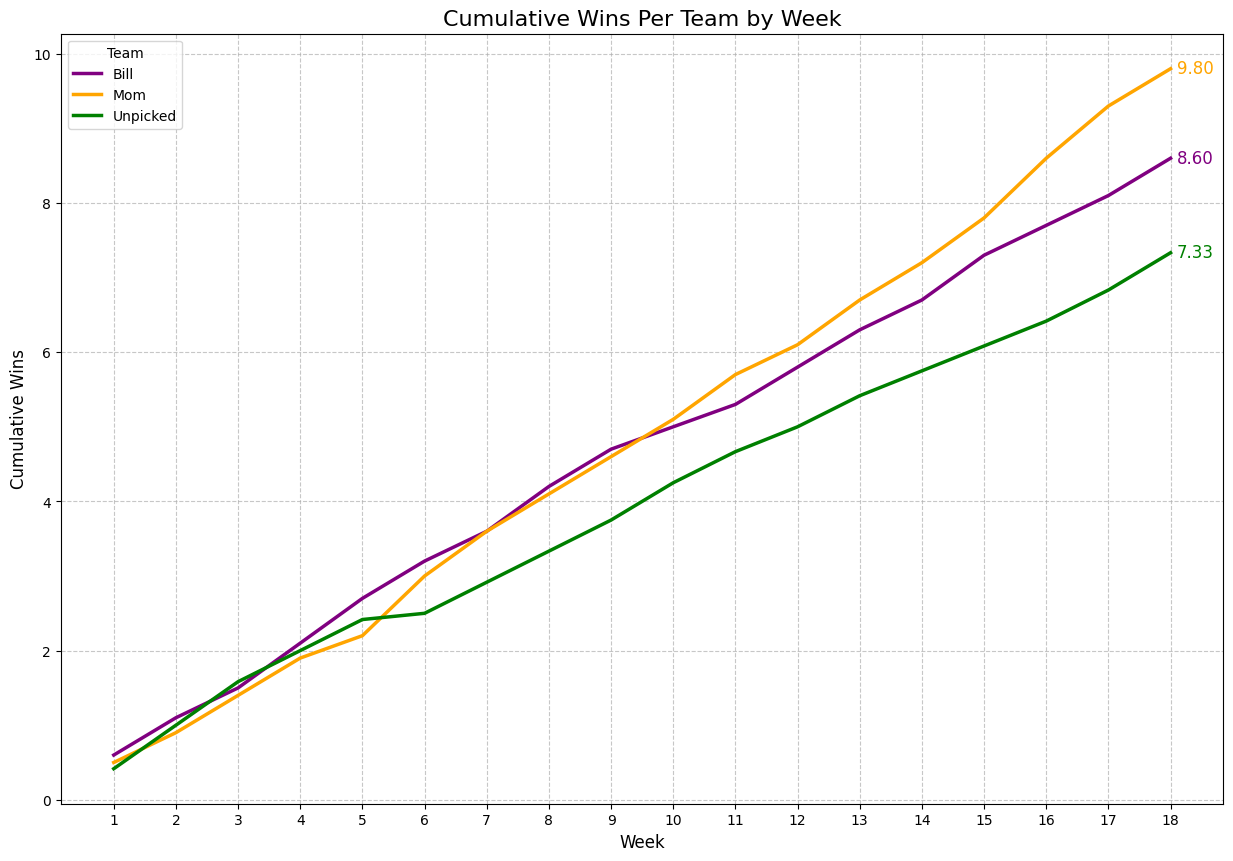

In [12]:
# Getting weekly Wins by team
weekly_wins = scores2.merge(fantasy_team_df, how='inner', left_on='winner', right_on='team')

plt, weekly_wins_filename = cum_win_func(weekly_wins, )
# Save the plot
weekly_wins_filename = f'Weekly_Wins_Week_{weekly_wins.week.max()}.png'
plt.savefig(fname=weekly_wins_filename)
plt.show()

## 4.) Formatting data and Designing AI Prompt

### 4.A) Connecting to Llama3

In [ ]:
# My Groq GPT AI Key
client = Groq(
    api_key="api_key_here"
)

### 4.B) Desgining Custom Lists of Input

In [14]:
# Long Team Names
team_longname_dict = {'HOU': 'Houston Texans', 'JAX': 'Jacksonville Jaguars', 'DAL': 'Dallas Cowboys', 'NYJ': 'New York Jets',
                      'KC': 'Kansas City Chiefs', 'PHI': 'Philadelphia Eagles', 'ATL': 'Atlanta Falcons', 'CHI': 'Chicago Bears',
                      'DET': 'Detroit Lions', 'BAL': 'Baltimore Ravens', 'GB': 'Green Bay Packers', 'LAC': 'Los Angeles Chargers',
                      'BUF': 'Buffalo Bills', 'CIN': 'Cincinnati Bengals', 'IND': 'Indianapolis Colts', 'MIA': 'Miami Dolphins',
                      'CLE': 'Cleveland Browns',
                      'LA': 'Los Angeles Rams', 'TB': 'Tampa Bay Buccaneers', 'SF': 'San Francisco 49ers',
                      'PIT': 'Shitsburg Steelers', 'ARI': 'Arizona Cardinals', 'TEN': 'Tennessee Titans', 
                      'NE': 'New England Patriots', 'CAR': 'Carolina Panthers', 'MIN': 'Minnesota Vikings', 'LV': 'Las Vegas Raiders',
                      'DEN': 'Denver Broncos', 'WAS': 'Washington Commanders', 'NO': 'New Orleans Saints', 
                      'NYG': 'New York Giants', 'SEA': 'Seattle Seahawks'
                     }

fantasy_team_df2 = fantasy_team_df.merge(pd.DataFrame(list(team_longname_dict.items()), columns=['team', 'long_name']),
                                        how='inner', on='team')

In [15]:
# Strings for the important Games:
important_games = pd.concat([head_to_heads, upsets, scores_week], ignore_index=True, axis=0).drop_duplicates()

top_games, rest_of_the_games = top_games_func(scores_week, important_games)

In [16]:
# Dictionary of wins per person
wins_dict = {
    'bill_wins': int(scores_week.bill_win.sum()),
    'mom_wins': int(scores_week.mom_win.sum()),
    'bill_hth_wins': int(scores_week[(scores_week.mom_team == 1) & (scores_week.bill_team == 1) & (scores_week.bill_win == 1)].bill_win.sum()),
    'mom_hth_wins': int(scores_week[(scores_week.mom_team == 1) & (scores_week.bill_team == 1) & (scores_week.mom_win == 1)].mom_win.sum()),
    'total_hth_games': int(scores_week[(scores_week.mom_team == 1) & (scores_week.bill_team == 1) & (scores_week.bill_win == 1)].bill_win.sum()) +
                       int(scores_week[(scores_week.mom_team == 1) & (scores_week.bill_team == 1) & (scores_week.mom_win == 1)].mom_win.sum()),
    'bill_max_wins': len(scores_week[scores_week.bill_team == 1]),
    'mom_max_wins': len(scores_week[scores_week.mom_team == 1]),
    'bill_season_wins': int(fantasy_wins[fantasy_wins.Player == 'Bill'].total_points.values[0]),
    'mom_season_wins': int(fantasy_wins[fantasy_wins.Player == 'Mom'].total_points.values[0]),
}

In [17]:
# Testing the final compiler
print(final_compiler(top_games.iloc[1, :], fantasy_team_df2, team_longname_dict, weekly_player))

Bill's New York Jets defeated Mom's Miami Dolphins by a score of 32.0 to 20.0. 


The New York Jets Quarterback, Aaron Rodgers, threw for 274.0 yards, with 4 touchdowns and 1.0 interceptions, at 7.61 yards per attempt and a completion percentage of 63.89%. 

The Miami Dolphins Quarterback, Tyler Huntley, threw for 227.0 yards, with 1 touchdowns and 2.0 interceptions, at 5.54 yards per attempt and a completion percentage of 60.98%. 
The leading rusher for New York Jets was Breece Hall, who carried 12 times for 57 yards (4.75 yards per attempt) and 0 touchdowns.

The leading receiver for New York Jets was Davante Adams, who had 6 receptions for 88 yards and 1 touchdowns.
Additionally, Tyler Conklin had 1 receiving touchdowns for The New York Jets.
Allen Lazard had 1 receiving touchdowns for The New York Jets.
Breece Hall had 1 receiving touchdowns for The New York Jets.

The leading rusher for Miami Dolphins was Devon Achane, who carried 11 times for 121 yards (11.0 yards per attempt) an

### 4.D) Writing the Prompt - One Game at a time

In [18]:
main_messages = [ {"role": "system", "content": 
          "You are a zany sports journalist reporting on the football games this weekend"} ]

message = f"""
Bill and Mom are in a special type of a Fantasy Football league. Instead of drafting players, they draft entire teams. \
For each win their teams get in the regular season, they get a point. 

The Football Teams are divided into 3 Squads:

Bill's Squad, comprised of: {fantasy_team_df2[fantasy_team_df2.Player == 'Bill'].long_name.values}
Mom's Squad, comprised of: {fantasy_team_df2[fantasy_team_df2.Player == 'Mom'].long_name.values}
Unpicked Squad, comprised of: {fantasy_team_df2[fantasy_team_df2.Player == 'Unpicked'].long_name.values}

Write the first paragraph of an aritlce summarizing this weekend's football games. \
This detailed paragraph should focus on the following stats:

Bill Wins: {wins_dict['bill_wins']}
Mom Wins: {wins_dict['mom_wins']}

Bill and Mom played {wins_dict['total_hth_games']} head-to-head games. Bill won {wins_dict['bill_hth_wins']} of those, and Mom won {wins_dict['mom_hth_wins']} of those.

Bill won {wins_dict['bill_wins']} out of a total of a possible {wins_dict['bill_max_wins']} this week, \
while mom won {wins_dict['mom_wins']} out of a total of a possible {wins_dict['mom_max_wins']} this week.
This doesn't mean that Bill has a {wins_dict['bill_wins']}-{wins_dict['bill_max_wins']} record. It just means he had a total of {wins_dict['bill_max_wins']} wins available\
and only got {wins_dict['bill_wins']}.

Bill has {wins_dict['bill_season_wins']} wins in total this season and Mom has {wins_dict['mom_season_wins']} wins in total this season.
Last week Bill had {wins_dict['bill_season_wins'] - wins_dict['bill_wins']}, while Mom had {wins_dict['mom_season_wins'] - wins_dict['mom_wins']}. Make sure to call this out.

Embellish where possible and make fun of the person who has fewer wins wherever possible. Be very funny. \
Don't start the article with "well, well, well" or "Fantasy Football Frenzy". Be more creative than that. \
Start with a unique and specific title to this week of football outcomes.
Include a title that is preceded by "TITLE: "
"""
main_messages.append(
        {"role": "user", "content": message},
    )

chat = client.chat.completions.create(
        model="llama-3.3-70b-versatile", messages=main_messages
    )
reply_intro = chat.choices[0].message.content

In [19]:
# Getting the game summaries of the top games
game_summaries = []

for i in range(3):
    main_messages2 = main_messages.copy()

    message = f"""
    Now, summarize this game:
    {final_compiler(top_games.iloc[i, :], fantasy_team_df2, team_longname_dict, weekly_player)}
    Embellish it to make it exciting.
    Don't talk about how this affects the standings between Bill and Mom.
    """
    
    
    
    main_messages2.append(
            {"role": "user", "content": message},
        )
    
    chat = client.chat.completions.create(
            model="llama-3.3-70b-versatile", messages=main_messages2
        )
    reply_game = chat.choices[0].message.content
    game_summaries.append(reply_game)
    time.sleep(10)

In [20]:
# The Rest of the Results
message = f"""
    Finally, wrap up this article by mentioning the rest of the results:
    {rest_of_the_games_func(rest_of_the_games, fantasy_team_df2, team_longname_dict)}.
    Only give me a quick run through of the rest of these games, including the scores and who's squad they're on. 
    Separate each game with a new line.
    Start with "Here's what else happened across the league:"
    """

main_messages.append(
            {"role": "user", "content": message},
        )
    
chat = client.chat.completions.create(
        model="llama-3.3-70b-versatile", messages=main_messages
    )
rest_of_games_recap = chat.choices[0].message.content

rest_of_games_recap += "\n \n"

In [21]:
final_article = reply_intro
final_article += "\n \nGAME SUMMARIES: \n"

for i in range(3):
    final_article += "\n" + "\n" + f"GAME {i+1}:" + "\n" + game_summaries[i]

final_article += "\n \n" + rest_of_games_recap

## 6.) Sending Email

### 6.A) Formatting the reply

In [22]:
# Bolding the proper words
final_article2 = final_article
words_to_bold = weekly_player.player_display_name.values
for word in words_to_bold:
    final_article2 = final_article2.replace(word, f"<b>{word}</b>")

# Preserving the Spacing
final_article2 = final_article2.replace("\n", "<br>")

# Removing the word "Title"
final_article2 = final_article2.replace('TITLE: ', '')

In [23]:
# Adding an asterisk
final_article2 += """


<i>Thank you for reading this completely AI-generated (except this part, which Bil wrote) and fully automated article. \
If this is your first time reading, welcome! Here's a quick summary on what this is:

Bill and Mom are in an annual Fantasy Football competition, where they pick teams instead of players. For each win one of their teams \
gets, they get one point. Pretty simple. At the end of the year, whoever has the most points wins!

What you've just read was an AI-generated article created by Bill. He scraped the NFL data, loaded it, transformed it, formatted it, \
and fed it into an AI with custom prompting (easier said than done). He then automated the script so that it is sent out to this \
distribution list every Tuesday at 10:00 AM PST with literally no human involvement. 

And yes. That's very cool. </i> 
"""

In [24]:
# Format the content dynamically
formatted_message = format_email_content(final_article2)

In [25]:

display(Markdown(formatted_message))

<p style="font-size: 24px;">Gridiron Gridlock: Bill and Mom Locked in a Ferocious Fight for Fantasy Football Supremacy</p><br><br>In a weekend that will be etched in the annals of fantasy football history as one of the most electrifying and unpredictable, Bill and Mom found themselves deadlocked in a 5-5 stalemate, with each racking up an impressive five wins to keep their squads firmly entrenched in the running. The head-to-head matchups between the two fantasy football foes were nothing short of thrilling, with Bill emerging victorious in two of the four contests and Mom snagging the remaining two - because, let's be real, someone's got to keep Bill's ego in check. But here's the real kicker: both Bill and Mom had a total of 10 wins up for grabs, and they each managed to snag exactly half of those, leaving the rest to wither away like a Browns fan's hopes of a championship. And if you thought things were getting boring, think again - Bill and Mom are now tied for the season with a whopping 134 wins apiece, a staggering five-win improvement over last week's tally of 129, which, might I add, was a pretty pathetic showing from both of these fantasy football "powerhouses." One can only imagine the trash talk that's been flying back and forth between these two, with Bill probably saying something like, "Hey, Mom, I've got a whole squad of Cowboys, and they're all lassoing wins like it's their job!" And Mom retorting with, "Oh yeah, Bill, but my Ravens are flying high, and they're not about to get knocked out of the sky by your bunch of Texans!" Okay, maybe that's not exactly how the conversation went, but one thing's for sure - with these two locked in a fierce battle for fantasy football dominance, things are about to get really, really interesting.<br> <br>GAME SUMMARIES: <br><br><br>GAME 1:<br>"Gridiron Gauntlet: The Unpredictable Upswings of Week's End"<br><br>In a shocking turn of events, Bill's Chicago Bears pulled off a stunning upset against Mom's heavily favored Green Bay Packers, with a nail-biting 24-22 victory that left the gridiron gasping for air. The Packers, bolstered by a 10-point advantage, were expected to steamroll their way to an easy win, but the Bears had other plans. Like a swarm of angry bees, they descended upon the Packers, determined to take down the giants. And take them down they did, in a thrilling display of football finesse that will be etched in the memories of fans for weeks to come.<br><br>At the heart of the Bears' onslaught was their fearless quarterback, <b>Caleb Williams</b>, who threw for 148 yards, including a dazzling touchdown, while maintaining a pristine record of zero interceptions. His Packers counterpart, <b>Malik Willis</b>, put up a valiant effort, tossing for 136 yards, but ultimately fell short of the mark. The Packers' ground game, led by the indefatigable <b>Emanuel Wilson</b>, who racked up 73 yards and a touchdown on 14 carries, threatened to overwhelm the Bears, but they stood firm, like a fortress of gridiron grit.<br><br>Meanwhile, the Bears' <b>D'Andre Swift</b> proved to be a force to be reckoned with, pounding out 65 yards on 20 carries, including a crucial touchdown that left the Packers reeling. And then, there was the spectacular <b>D.J. Moore</b>, who hauled in an astonishing 9 receptions for 86 yards, including a touchdown that will be replayed on highlight reels for eternity. The Bears' triumphant cries echoed through the stadium, a deafening declaration of their unwavering determination to take down their opponents, no matter the odds. In the end, it was a David-vs-Goliath battle for the ages, with the Bears emerging victorious, their paws raised in triumph, as the Packers slunk away, vanquished and bewildered.<br><br>GAME 2:<br>Gridiron Glory: Rodgers Runs Wild as Jets Soar Over Dolphins<br><br>In a thrilling showdown that left fans on the edge of their seats, Bill's New York Jets took to the skies and delivered a resounding 32-20 victory over Mom's Miami Dolphins. The mastermind behind this aerial assault was none other than the incomparable <b>Aaron Rodgers</b>, who threw for a dazzling 274 yards, unleashing a quartet of touchdowns and just one interception. The Dolphins' defense was left scrambling to keep up with Rodgers' lightning-quick reflexes and pinpoint accuracy, as he torched them for 7.61 yards per attempt and a scorching 63.89% completion rate.<br><br>Meanwhile, the Dolphins' <b>Tyler Huntley</b> put up a valiant effort, but his stats paled in comparison to Rodgers' fireworks display. Huntley managed a respectable 227 yards, but his two interceptions and relatively modest 5.54 yards per attempt left the Dolphins' offense sputtering. The usually-reliable Huntley was pressured relentlessly by the Jets' defense, which seemed to be one step ahead of him all game long.<br><br>On the ground, the Jets' <b>Breece Hall</b> pounded out a workmanlike 57 yards on 12 carries, setting the tone for a balanced Jets attack. But it was the Jets' receiving corps that truly stole the show, with <b>Davante Adams</b> hauling in six passes for 88 yards and a touchdown. The dynamic trio of <b>Tyler Conklin</b>, <b>Allen Lazard</b>, and <b>Breece Hall</b> all chipped in with touchdown catches of their own, leaving the Dolphins' secondary grasping at air.<br><br>In a rare bright spot for the Dolphins, rookie sensation <b>Devon Achane</b> exploded for 121 yards on just 11 carries, including a electrifying touchdown run that left the Jets' defense reeling. <b>Jonnu Smith</b> proved to be a reliable target for Huntley, snagging nine passes for 56 yards and a touchdown, but it was too little, too late for the beleaguered Dolphins. As the final whistle sounded, the Jets were left basking in the glory of their hard-fought 12-point triumph, while the Dolphins slunk away, already looking ahead to their next matchup.<br><br>GAME 3:<br>Gridiron Gauntlet: Colts Outgun Jaguars in Thrilling Showdown<br><br>In a heart-stopping, action-packed clash, Mom's Indianapolis Colts edged out Bill's Jacksonville Jaguars by a hair's breadth, 26-23. The Colts' signal-caller, <b>Joe Flacco</b>, orchestrated a masterful performance, throwing for 264 yards and a touchdown, while keeping his cool under pressure with zero interceptions. His counterpart, <b>Mac Jones</b>, put up a valiant effort, hurling for 225 yards and a touchdown, but a lone interception proved to be a costly mistake.<br><br>The real star of the show, however, was the Colts' powerhouse running back, <b>Jonathan Taylor</b>, who bulldozed his way to 177 yards on 34 carries, leaving a trail of would-be tacklers in his wake. His impressive 5.21 yards per attempt average left the Jaguars' defense reeling, and his touchdown sealed the deal for the Colts. On the receiving end, <b>Josh Downs</b> hauled in 10 receptions for 94 yards, a workhorse effort that kept the Colts' offense humming. Meanwhile, <b>Alec Pierce</b> snatched a crucial touchdown pass, sending the crowd into raptures.<br><br>On the other side of the ball, the Jaguars' <b>Tank Bigsby</b> and <b>Parker Washington</b> led the charge, with Bigsby rumbling for 39 yards and a touchdown, and Washington snagging a scoring pass. <b>Brian Thomas</b>, the Jaguars' top receiver, torched the Colts' secondary for 103 yards on seven receptions, but it wasn't enough to overcome the Colts' balanced attack. As the final whistle blew, the Colts celebrated a hard-fought victory, while the Jaguars licked their wounds, already looking ahead to the next showdown. The question on everyone's lips: can Bill's squad bounce back from this nail-biting defeat? Only time will tell.<br> <br>Gridiron Glory: Bill and Mom's Squads Slug it Out in a Weekend of Football Frenzy<br><br>In a weekend that will go down in fantasy football history as one of the most epic battles of wits, Bill and Mom's squads clashed in a series of head-to-head matchups that left fans on the edge of their seats. With a staggering 5 wins each, it's clear that these two fantasy football powerhouses are evenly matched. But let's dive deeper into the numbers, shall we? Bill won 5 out of a possible 10 games, while Mom also won 5 out of 10 - and with 4 head-to-head games between them, they split the victories right down the middle, with 2 wins apiece. This brings their total season wins to a whopping 134 each, a significant jump from last week's 129. It's worth noting that Bill didn't exactly "win" the weekend, per se - but hey, when you're tied with your opponent, you can't really claim bragging rights, can you, Bill?<br><br>Here's what else happened across the league:<br>Mom's Baltimore Ravens trounced Bill's Cleveland Browns 35.0 to 10.0.<br> <br>Mom's Tampa Bay Buccaneers took down Unpicked's New Orleans Saints 27.0 to 19.0.<br> <br>Unpicked's Denver Broncos annihilated Bill's Kansas City Chiefs 38.0 to 0.0.<br> <br>Unpicked's Carolina Panthers pulled off a stunning upset over Bill's Atlanta Falcons 44.0 to 38.0.<br> <br>Unpicked's Seattle Seahawks edged out Mom's Los Angeles Rams 30.0 to 25.0.<br> <br>Mom's Los Angeles Chargers cruised past Unpicked's Las Vegas Raiders 34.0 to 20.0.<br> <br>Unpicked's Washington Commanders squeaked out a win over Bill's Dallas Cowboys 23.0 to 19.0.<br> <br>Unpicked's Arizona Cardinals demolished Mom's San Francisco 49ers 47.0 to 24.0.<br> <br>Unpicked's New England Patriots defeated Mom's Buffalo Bills 23.0 to 16.0.<br> <br>Bill's Philadelphia Eagles eked out a win over Unpicked's New York Giants 20.0 to 13.0.<br> <br>Mom's Cincinnati Bengals narrowly defeated Unpicked's Shitsburg Steelers 19.0 to 17.0.<br> <br>Bill's Detroit Lions crushed Unpicked's Minnesota Vikings 31.0 to 9.0.<br> <br>


<i>Thank you for reading this completely AI-generated (except this part, which Bil wrote) and fully automated article. If this is your first time reading, welcome! Here's a quick summary on what this is:

Bill and Mom are in an annual Fantasy Football competition, where they pick teams instead of players. For each win one of their teams gets, they get one point. Pretty simple. At the end of the year, whoever has the most points wins!

What you've just read was an AI-generated article created by Bill. He scraped the NFL data, loaded it, transformed it, formatted it, and fed it into an AI with custom prompting (easier said than done). He then automated the script so that it is sent out to this distribution list every Tuesday at 10:00 AM PST with literally no human involvement. 

And yes. That's very cool. </i> 


### 6.B) Email Sending

In [ ]:
# Email details
from_email = 'from_email@gmail.com'
to_emails = ['to_email@gmail.com']
subject = f"Week {week} Bill/Mom Fantasy Wrap Up"
body = formatted_message
# body = html_formatted_message

# Set up the SMTP server
smtp_server = "smtp.gmail.com"
port = 587  # or 465 for SSL


login = "email.gmail.com"  # your email login
password = "password"  # your email password

# Create the message
msg = MIMEMultipart()
msg['From'] = from_email
msg['To'] = ", ".join(to_emails)  # join the list into a comma-separated string
msg['Subject'] = subject

# Attach the body text to the message
msg.attach(MIMEText(body, 'html'))

image_path = weekly_wins_filename

# Attach the image
with open(image_path, "rb") as img_file:
    img = MIMEImage(img_file.read())
    img.add_header("Content-ID", "<generated_image>")
    img.add_header("Content-Disposition", "inline", filename=f"WeeklyWinsPerTeam_Week{weekly_wins.week.max()}.png")
    msg.attach(img)

# Send the email
try:
    server = smtplib.SMTP(smtp_server, port)
    server.starttls()  # Upgrade the connection to secure
    server.login(login, password)
    text = msg.as_string()
    server.sendmail(from_email, to_emails, text)
    print("Email sent successfully!")
except Exception as e:
    print(f"Error: {e}")
finally:
    server.quit()


Email sent successfully!
